<a href="https://colab.research.google.com/github/dhruvmetha/learning_activations/blob/main/adpative_activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
#activation with parameters
class Activation(nn.Module):
    def __init__(self, inp, out):
      super(Activation, self).__init__()
      self.fc1 = nn.Linear(inp, out)

    def forward(self, x):     
      z = x.shape
      x = self.fc1(x)   
      return x.view(z)

#1 layer hidden neural network with parameters
class Model(nn.Module):
    def __init__(self, input_dim):
      super(Model, self).__init__()
      self.layer1 = nn.Linear(input_dim, 1)
      self.act = Activation(1, 1)
      self.layer2 = nn.Linear(1, 3)

        
    def forward(self, x):
      x = self.layer1(x)
      x = self.act(x) #using custom Activation
      x = self.layer2(x)
      return x

In [14]:
#data loading and preprocessing
features, labels = load_iris(return_X_y=True)
features = preprocessing.normalize(features)
features_train,features_test, labels_train, labels_test = train_test_split(features, labels, random_state=42, shuffle=True)

In [15]:
#Initialization of the model
model = Model(features_train.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
epochs = 250

In [16]:
#validation tests with f1 score
def test(x, y):
  test_lossfn = nn.CrossEntropyLoss(reduction='sum')
  x, y = Variable(torch.from_numpy(x)).float(), Variable(torch.from_numpy(y)).long()
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    output = model(x)
    test_loss += test_lossfn(output, y).item()  # sum up batch loss
    output = F.log_softmax(output)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    f1 = f1_score(y, pred, average=None)
    correct += pred.eq(y.view_as(pred)).sum().item()

  test_loss /= x.shape[0]
  accuracy = correct / x.shape[0]
  return test_loss, accuracy, f1

torch.Size([112, 4])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Accuracy')

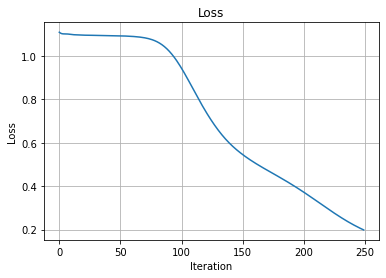

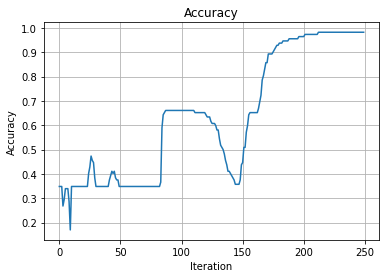

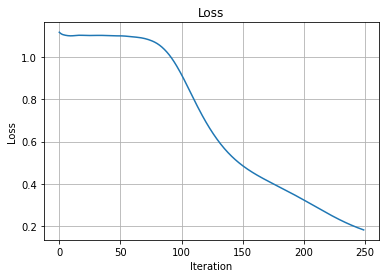

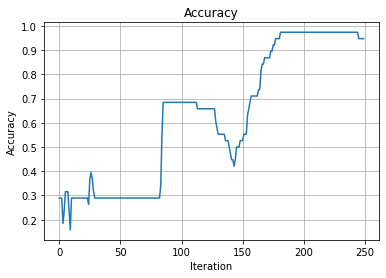

In [17]:
#training
x_train, y_train = Variable(torch.from_numpy(features_train)).float(), Variable(torch.from_numpy(labels_train)).long()
print(x_train.shape)
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

K = []

for epoch in range(1, epochs+1):
    model.train()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    train_loss.append(loss.data.numpy())
    
    K.append([model.act.fc1.bias.item(), model.act.fc1.weight.item()])
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step() 

    val_loss, val_acc, _ = test(features_test, labels_test)
    test_loss.append(val_loss)
    test_accuracy.append(val_acc)

    _, train_acc, _ = test(features_train, labels_train)
    train_accuracy.append(train_acc)

plt.figure()
plt.plot(train_loss)
plt.title('Loss')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')  

plt.figure()
plt.plot(train_accuracy)
plt.title('Accuracy')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')


plt.figure()
plt.plot(test_loss)
plt.title('Loss')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')  

plt.figure()
plt.plot(test_accuracy)
plt.title('Accuracy')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [18]:
#test on validation set
loss, accuracy, f1_score = test(features_test, labels_test)
loss, accuracy, f1_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


(0.18110112140053197,
 0.9473684210526315,
 array([1.        , 0.90909091, 0.91666667]))

Text(0, 0.5, 'g(z)')

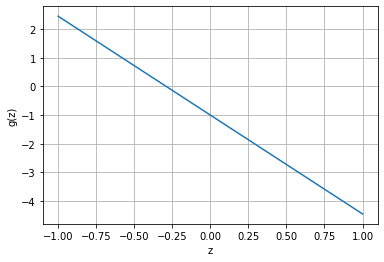

In [19]:
# ploting change in k0 and k1 through the training process
model.eval()
plt.figure()
z = torch.linspace(-1,1,1000); 
plt.plot(z.numpy(),model.act(z.unsqueeze(-1)).detach().numpy())
plt.grid()
plt.xlabel('z')
plt.ylabel('g(z)')

In [20]:
#Final k0 and k1
model.act.fc1.weight, model.act.fc1.bias

(Parameter containing:
 tensor([[-3.4557]], requires_grad=True), Parameter containing:
 tensor([-1.0006], requires_grad=True))

Text(0, 0.5, 'k1')

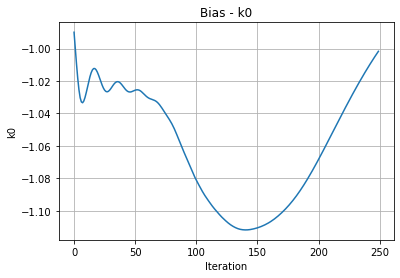

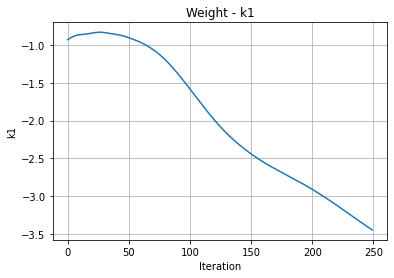

In [21]:
K = np.array(K)

plt.figure()
plt.plot(K[:, 0])
plt.title('Bias - k0')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('k0')  

plt.figure()
plt.plot(K[:, 1])
plt.title('Weight - k1')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('k1')